In [1]:
%pylab inline

from __future__ import print_function
import numpy as np
import theano
import theano.tensor as T
import time
import datetime
import os

import lasagne
from copy import deepcopy

import SimpleITK as sitk

Populating the interactive namespace from numpy and matplotlib


In [2]:
mri_sitk = sitk.ReadImage("CNN_testing_data/case_041_ax_space_trial.mha")
mri = sitk.GetArrayFromImage(mri_sitk)

label_sitk = sitk.ReadImage("CNN_testing_data/case_041_ax_space_trial-label.nrrd")
label = sitk.GetArrayFromImage(label_sitk)

assert mri.shape == label.shape

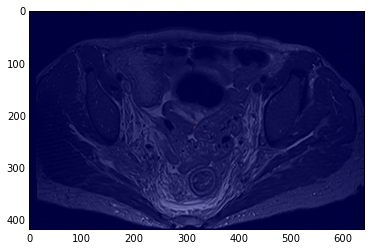

In [3]:
imshow(mri[101,:,:], cmap="gray")
imshow(label[101,:,:], interpolation="nearest", alpha=0.5)

In [4]:
a, b, c = label.shape
print(a,b,c)

112 416 640


In [ ]:
batchsize = 3
nb_classes = 2
num_epochs = 3

train_cases = 6
test_cases = 6
val_cases = 6

# input image dimensions
img_slices, img_rows, img_cols = mri.shape
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = (2,2,1)
# convolution kernel size
nb_conv = (3,3,3)


X_train = np.zeros((train_cases, img_slices, img_rows, img_cols), dtype=np.float32)
y_train = np.zeros((train_cases, img_slices, img_rows, img_cols), dtype=np.int32)
X_val = np.zeros((val_cases, img_slices, img_rows, img_cols), dtype=np.float32)
y_val = np.zeros((val_cases, img_slices, img_rows, img_cols), dtype=np.int32)
X_test = np.zeros((test_cases, img_slices, img_rows, img_cols), dtype=np.float32)
y_test = np.zeros((test_cases, img_slices, img_rows, img_cols), dtype=np.int32)

for i in range(train_cases):
    X_train[i,:,:,:] = deepcopy(mri).astype(np.float32)
    y_train[i,:,:,:] = deepcopy(label).astype(np.int32)

for i in range(val_cases):
    X_val[i,:,:,:] = deepcopy(mri).astype(np.float32)
    y_val[i,:,:,:] = deepcopy(label).astype(np.int32)
    
for i in range(test_cases):
    X_test[i,:,:,:] = deepcopy(mri).astype(np.float32)
    y_test[i,:,:,:] = deepcopy(label).astype(np.int32)

m,s = np.mean(X_train), np.std(X_train)
X_train -= m
X_train /= s
X_test -= m
X_test /= s
X_val -= m
X_val /= s
print('X_train shape:', X_train.shape)
print(train_cases, 'train samples')
print(test_cases, 'test samples')

X_train shape: (6, 112, 416, 640)
6 train samples
6 test samples


In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    print(len(inputs), len(targets))
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
def build_cnn(single_entry_shape, input_var=None):
    # As a third model, we'll create a CNN of two convolution + pooling stages
    # and a fully-connected hidden layer in front of the output layer.

    # Input layer, as usual:
    network = lasagne.layers.InputLayer(shape=(None, single_entry_shape[0], single_entry_shape[1], 
                                               single_entry_shape[2]),
                                        input_var=input_var)
    # This time we do not apply input dropout, as it tends to work less well
    # for convolutional layers.

    # Convolutional layer with 32 kernels of size 5x5. Strided and padded
    # convolutions are supported as well; see the docstring.
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=6, filter_size=(11, 11), 
            nonlinearity=lasagne.nonlinearities.leaky_rectify,
            W=lasagne.init.HeNormal())
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    # Expert note: Lasagne provides alternative convolutional layers that
    # override Theano's choice of which implementation to use; for details
    # please see http://lasagne.readthedocs.org/en/latest/user/tutorial.html.    
    
    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=3, filter_size=(5, 5), 
            nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    ########
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=2, filter_size=(3, 3), 
            nonlinearity=lasagne.nonlinearities.leaky_rectify)
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    ###network = lasagne.layers.Conv2DLayer(
    ###        network, num_filters=50, filter_size=(3, 3), 
    ###        nonlinearity=lasagne.nonlinearities.leaky_rectify)
    ###network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    """
    network = lasagne.layers.DenseLayer(
           lasagne.layers.dropout(network, p=.5),
            num_units=20,
           nonlinearity=lasagne.nonlinearities.leaky_rectify)
    """
    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=2,
            nonlinearity=lasagne.nonlinearities.softmax) #leaky_rectify
    
    network = lasagne.layers.ReshapeLayer(network, (1, 112, 416, 640))

    return network

In [ ]:
num_epochs = 3 # 100
batchsize = 3
single_entry_shape = X_train.shape[1:]

# Prepare Theano variables for inputs and targets
input_var = T.tensor4('inputs')
target_var = T.itensor4('targets')

network = build_cnn(single_entry_shape, input_var)

# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var) # multiclass_hinge_loss
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9) #0.00001
###updates = lasagne.updates.rmsprop(
###        loss, params, learning_rate=0.001)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var) # multiclass_hinge_loss
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),  # axis=1
                    dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates)

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

# Finally, launch the training loop.
print("Starting training...")
# We iterate over epochs:
for epoch in range(num_epochs):
    
    now = datetime.datetime.now()
    print("Epoch %d started on %s" % (epoch + 1, now.strftime("%Y-%m-%d %H:%M")))
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batchsize, shuffle=True):
        inputs, targets = batch
        #inputs, targets = X_train[0,:,:,:], y_train[0,:,:,:]
        train_err += train_fn(inputs, targets)
        train_batches += 1

    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batchsize, shuffle=False):
        inputs, targets = batch
        #inputs, targets = X_val[0,:,:,:], y_val[0,:,:,:]
        err, acc = val_fn(inputs, targets)
        val_err += err
        val_acc += acc
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

# After training, we compute and print the test error:
test_err = 0
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, batchsize, shuffle=False):
    inputs, targets = batch
    #inputs, targets = X_test[0,:,:,:], y_test[0,:,:,:]
    err, acc = val_fn(inputs, targets)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()

model.add(Convolution3D(nb_filters, nb_conv[0], nb_conv[1], nb_conv[2],
                        border_mode='valid',
                        input_shape=(1, img_slices, img_rows, img_cols)))
model.add(Activation('relu'))

model.add(Convolution3D(nb_filters, nb_conv[0], nb_conv[1], nb_conv[2]))
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[1], nb_pool[2])))

model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
#model.add(Activation('softmax', output_))
model.add(Activation('softmax', output_shape=(1, img_slices, img_rows, img_cols)))
model.add(Reshape((img_slices, img_rows, img_cols)))

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)